## **Imports**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

##**Loading Data**




In [ ]:
file_path = 'all_weather_data.csv'
basic_df = pd.read_csv(file_path)
basic_df = basic_df.sample(frac=0.1, random_state=42)
basic_df.describe()

,min_temp °c,max_temp °c,rain mm,humidity %,cloud_cover %,wind_speed km/h,wind_direction_numerical
count,283619.000000,283619.000000,283619.000000,283619.000000,283619.000000,283619.000000,283619.000000
mean,7.095121,13.155603,2.504945,82.354398,56.109979,16.074798,198.894053
std,4.862391,5.860088,4.546878,8.852784,25.530083,7.393027,73.476368
min,-24.000000,-16.000000,0.000000,14.000000,0.000000,1.000000,0.000000
25%,4.000000,9.000000,0.000000,77.000000,37.000000,11.000000,157.500000
50%,7.000000,13.000000,0.400000,83.000000,58.000000,15.000000,202.500000
75%,11.000000,17.000000,3.100000,89.000000,76.000000,20.000000,247.500000
max,30.000000,43.000000,138.300000,100.000000,100.000000,62.000000,337.500000


#Basic Model Pipeline

In [ ]:
# Check for missing values in the dataset
print("Missing values in each column:")
print(basic_df.isna().sum())
basic_df = basic_df.dropna()  # Drop rows with missing values

Missing values in each column:
location                    0
date                        0
min_temp °c                 0
max_temp °c                 0
rain mm                     0
humidity %                  0
cloud_cover %               0
wind_speed km/h             0
wind_direction              0
wind_direction_numerical    0
dtype: int64


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply Label Encoding to the 'City' column
basic_df['location_encoded'] = label_encoder.fit_transform(basic_df['location'])

# Convert to datetime
basic_df['date'] = pd.to_datetime(basic_df['date'])

reference_date = pd.to_datetime('2009-01-01')

# Calculate the difference in days
basic_df['date_in_days'] = (basic_df['date'] - reference_date).dt.days


import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Features (X) and Target (y)
basic_X = basic_df.drop(columns=['rain mm', 'location', 'date', 'wind_direction'])
basic_y = basic_df['rain mm']

# Split data
basic_X_train, basic_X_test, basic_y_train, basic_y_test = train_test_split(basic_X, basic_y, test_size=0.2, random_state=42)

# Create the XGBRegressor model with 'gblinear' booster for linear regression
model = xgb.XGBRegressor(objective='reg:squarederror', booster='gblinear', eval_metric='rmse')

# Train the model
model.fit(basic_X_train, basic_y_train)

# Predict on the test set
basic_y_pred = model.predict(basic_X_test)

## Error analysis

In [ ]:
# Calculate MSE, RMSE, MAE, and R-squared
basic_mse = mean_squared_error(basic_y_test, basic_y_pred)
basic_rmse = np.sqrt(basic_mse)
basic_mae = mean_absolute_error(basic_y_test, basic_y_pred)
basic_r2 = r2_score(basic_y_test, basic_y_pred)

print(f"Basic Mean Squared Error: {basic_mse:.4f}")
print(f"Basic Root Mean Squared Error: {basic_rmse:.4f}")
print(f"Basic Mean Absolute Error: {basic_mae:.4f}")
print(f"Basic R-squared Score: {basic_r2:.4f}")


Basic Mean Squared Error: 16.4605
Basic Root Mean Squared Error: 4.0572
Basic Mean Absolute Error: 2.5345
Basic R-squared Score: 0.2238


#1. Error Analysis Conclusions & work plan

* **Underestimating High Values:** The model is underestimating higher values, likely due to biases from underrepresentation of high values in the training data or model simplicity that cannot capture large magnitude patterns effectively. Certain features might be negatively impacting predictions, possibly due to improper scaling, irrelevant features, or complex interactions not being properly captured by the model.
* **Issues with Location Encoding:** Location is crucial for rain prediction due to factors like topography, proximity to water bodies, and climate zones. These differences affect rainfall patterns, which the model must capture. Using label encoding for location can lead to issues, as it treats location as a simple categorical variable, ignoring important geographic and meteorological differences. This can result in the model failing to capture location-specific weather patterns, leading to inaccurate predictions.
* **Seasonal Trends in Date Features:** Dates are important for rain prediction because weather patterns follow seasonal and cyclical trends. Using days from epoch in our model treats dates as a continuous number, missing these patterns. Rainfall varies by month, day of the week, and season, and this approach overlooks those cycles.
* **Avoiding Negative Predictions:** Negative predictions in rainfall (mm) are a clear error, as rainfall can never be negative. These factors allow the model to generate unrealistic outputs.
* **Handling Multicollinearity:** If features are highly correlated with each other (multicollinearity) or include irrelevant variables, the regular linear regression model may struggle to assign proper weights. In cases of multicollinearity, the model can assign large or unstable weights to correlated features, making it difficult to interpret which feature truly impacts predictions. Additionally, irrelevant features that don't provide meaningful information may still receive non-zero weights, adding unnecessary noise. Both issues lead to increased model complexity, reducing its ability to generalize and causing errors due to high bias and sensitivity to slight changes in the data.

##Conclusions:

To address these challenges, the following steps are planned to mitigate errors and enhance model performance:
* **Underestimating High Values:** Ensure all features are properly scaled to improve the performance.
* **Issues with Location Encoding:** We can represent the 'location' column in a way that retains the important geographic differences that affect rainfall. We intend to use one-hot encoding, which creates a separate binary feature for each location. While this increases the number of features, it ensures that the model can consider the unique impact of each location without treating it as just another categorical variable. This way, we can preserve the critical role of location in predicting rainfall.
* **Seasonal Trends in Date Features:** To capture seasonal trends in dates, we can extract features that reflect the natural cycles in weather patterns. We intend to do this by creating features for the months (1-12) and seasons (e.g., winter, spring) to represent yearly cycles.
* **Avoiding Negative Predictions:** To prevent negative rainfall predictions, the model's outputs can be post-processed using the clip function, which ensures all predicted values are constrained to a minimum of zero, maintaining the physical realism of the predictions.
* **Handling Multicollinearity:**
  * Use a correlation matrix or statistical tests to identify and remove redundant features.
  * Cross-validation can help identify whether multicollinearity or redundant features are causing instability, as inconsistent performance across folds might indicate issues with the feature set or regularization.

#2.  Improving Model Performance

In [ ]:
file_path = 'all_weather_data.csv'
df = pd.read_csv(file_path)
df = df.sample(frac=0.1, random_state=42)
df.describe()

,min_temp °c,max_temp °c,rain mm,humidity %,cloud_cover %,wind_speed km/h,wind_direction_numerical
count,283619.000000,283619.000000,283619.000000,283619.000000,283619.000000,283619.000000,283619.000000
mean,7.095121,13.155603,2.504945,82.354398,56.109979,16.074798,198.894053
std,4.862391,5.860088,4.546878,8.852784,25.530083,7.393027,73.476368
min,-24.000000,-16.000000,0.000000,14.000000,0.000000,1.000000,0.000000
25%,4.000000,9.000000,0.000000,77.000000,37.000000,11.000000,157.500000
50%,7.000000,13.000000,0.400000,83.000000,58.000000,15.000000,202.500000
75%,11.000000,17.000000,3.100000,89.000000,76.000000,20.000000,247.500000
max,30.000000,43.000000,138.300000,100.000000,100.000000,62.000000,337.500000


##**Modify data**

1. One-Hot Encoding for 'location' Column

In [ ]:
df = pd.get_dummies(df, columns=['location'], prefix='location')

2. Convert 'date' Column to Datetime

In [ ]:
df['date'] = pd.to_datetime(df['date'])

3. Extract Month and One-Hot Encode

In [ ]:
df['month'] = df['date'].dt.month
df = pd.get_dummies(df, columns=['month'], prefix='month')

4. Assign Seasons Based on Month

In [ ]:
# Winter: Dec (12), Jan (1), Feb (2); Spring: Mar (3), Apr (4), May (5);
# Summer: Jun (6), Jul (7), Aug (8); Autumn: Sep (9), Oct (10), Nov (11)
def assign_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'autumn'

df['season'] = df['date'].dt.month.apply(assign_season)

5. One-Hot Encoding for 'season' Column

In [ ]:
df = pd.get_dummies(df, columns=['season'], prefix='season')

##**Improved Model Pipeline**

Features (X) and Target (y)

In [ ]:
X = df.drop(columns=['rain mm', 'date', 'wind_direction'])
y = df['rain mm']

In [ ]:
# Ensure all columns are numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Replace NaN and infinite values
X = X.replace([np.inf, -np.inf], np.nan).fillna(X.mean())

6. calculate the correlation matrix and identify highly correlated features (correlation > 0.9). The highly correlated features will be removed

In [ ]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed

# Ensure all columns in X are numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Replace NaN and infinite values with a suitable value (e.g., 0 or mean)
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

# Step 1: Compute the correlation matrix using Pandas
correlation_matrix = X.corr()

# Step 2: Identify highly correlated features
# Only consider the upper triangle of the correlation matrix
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find features with a correlation above the threshold (e.g., 0.85)
threshold = 0.85
to_drop = [
    column for column in upper_triangle.columns
    if any(upper_triangle[column] > threshold)
]

print(f"Features to drop due to high correlation: {to_drop}")

# Step 3: Drop the identified features
X = X.drop(columns=to_drop)

# Print the reduced DataFrame
print(f"Shape of original data: {X.shape}")
print(f"Shape of reduced data: {X.shape}")

Features to drop due to high correlation: ['max_temp °c']
Shape of original data: (283619, 525)
Shape of reduced data: (283619, 525)


7. scale the features using StandardScaler

In [ ]:
# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

train model

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create the XGBRegressor model with 'gblinear' booster for linear regression
model = xgb.XGBRegressor(objective='reg:squarederror', booster='gblinear', eval_metric='rmse')

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Clip predictions to ensure no negative values
y_pred_clipped = np.clip(y_pred, 0, None)  # Clipping values below 0 to 0

##**Error Analysis**

In [ ]:
# Calculate MSE, RMSE, MAE, and R-squared
improved_mse = mean_squared_error(y_test, y_pred_clipped)
improved_rmse = np.sqrt(improved_mse)
improved_mae = mean_absolute_error(y_test, y_pred_clipped)
improved_r2 = r2_score(y_test, y_pred_clipped)

print(f"{'Metric':<30}{'Basic':<20}{'Improved':<20}")
print(f"{'-' * 70}")
print(f"{'Mean Squared Error':<30}{basic_mse:<20.4f}{improved_mse:<20.4f}")
print(f"{'Root Mean Squared Error':<30}{basic_rmse:<20.4f}{improved_rmse:<20.4f}")
print(f"{'Mean Absolute Error':<30}{basic_mae:<20.4f}{improved_mae:<20.4f}")
print(f"{'R-squared Score':<30}{basic_r2:<20.4f}{improved_r2:<20.4f}")

Metric                        Basic               Improved            
----------------------------------------------------------------------
Mean Squared Error            16.4605             15.4185             
Root Mean Squared Error       4.0572              3.9266              
Mean Absolute Error           2.5345              2.3524              
R-squared Score               0.2238              0.2729              


#3.   Analyzing the Improved Model and Drawing Conclusions

**Mean Squared Error:** decreased from 16.4605 to 15.4185

**Root Mean Squared Error:** decreased from 4.0572 to 3.9266

**Explanation:**
The MSE/RMSE decreased beacuse we made the following improvements:
* Proper Feature Scaling: By reducing noise from unbalanced feature scales, the model achieves better predictions and lowers overall error.
* Improved Location Encoding: By correctly encoding this critical feature, the model can better leverage geographic differences in rainfall patterns, reducing prediction errors.
* Incorporating Seasonal Trends: These features help the model generalize better across the data, leading to more accurate predictions and a lower MSE/RMSE.
* Avoiding Negative Predictions: This adjustment avoids artificially high squared errors caused by negative predictions, directly reducing MSE/RMSE.
* Handling Multicollinearity: With reduced multicollinearity, the model becomes more stable, leading to consistent predictions and improved error metrics.

Each of these adjustments improved the model’s ability to predict rainfall accurately, thereby reducing the mean squared difference between predicted and actual values.

**Mean Absolute Error:** decreased from 2.5345 to 2.3524

**Explantion:**
The MAE decreased beacuse we made the following improvements:
* Proper Feature Scaling: Improved the model's ability to make consistent predictions, reducing the average magnitude of errors.
* Improved Location Encoding: More accurate predictions across different locations led to a lower average error.
* Incorporating Seasonal Trends: Capturing seasonality improved the model's overall accuracy, lowering the mean absolute differences between predicted and actual rainfall.
* Avoiding Negative Predictions: Clipping predictions to realistic values reduced the absolute errors, especially for cases where the model might have predicted significantly negative values.
* Handling Multicollinearity: With redundant features removed, the model avoided overfitting, leading to smaller average errors across the test set.

**R^2:** increased from 0.2238 to 0.2729.

**Explanation:**
The R^2 increased because we made the following improvement:
* Proper Feature Scaling: By scaling the features, the model better identified patterns in the data, reducing residual errors , leading to an increase in R^2.
*  Improved Location Encoding: One-hot encoding allowed the model to treat each location independently, capturing geographic variations in rainfall more accurately. This improved the model’s ability to explain variance in rainfall patterns, increasing R^2.
* Incorporating Seasonal Trends: Adding month and season features helped the model account for cyclical patterns in weather (e.g., rainy vs. dry seasons). This significantly improved the model's ability to explain variations in rainfall throughout the year, boosting R^2.
* Avoiding Negative Predictions: Clipping predictions to non-negative values ensured better alignment with actual rainfall, reducing error variance and increasing R^2.
* Handling Multicollinearity: Removing redundant features focused the model on the most informative ones, improving generalization and reducing residual errors, which increased R^2.

The improved model performed better than the baseline, showing reductions in error metrics like MSE an increases in R^2 and a more stable prediction range. However, the improvement was not as significant as we had anticipated. While the adjustments contributed to better predictions, the relatively modest gains suggest that the chosen model architecture—using a linear booster (gblinear)—may not be the best fit for the complexity of the dataset. Rainfall prediction often involves nonlinear relationships and intricate interactions between features like cloud cover, humidity, and temperature, which a linear model might struggle to capture effectively. This indicates that exploring more sophisticated models, such as tree-based methods or neural networks, might yield better results.

###**Permutation Importance:**

Permutation Importance is a model-agnostic technique used to evaluate the importance of features in a predictive model. It measures the change in a model's performance when the values of a particular feature are randomly shuffled. By shuffling, the relationship between that feature and the target variable is broken, and any drop in model performance indicates how much the model depends on that feature.

Unlike methods that focus on internal model parameters, permutation importance assesses how each feature actually affects the model’s predictions. This gives a clearer picture of feature importance in the context of your data and target variable.

It will help us gain insights into which features most influence rainfall predictions, providing actionable insights for meteorological analysis.

In [ ]:
from sklearn.inspection import permutation_importance

# Compute permutation importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=2, random_state=42)


                      feature  importance       std
3               cloud_cover %    0.322350  0.007149
510                   month_2    0.183661  0.002791
4             wind_speed km/h    0.167685  0.002378
511                   month_3    0.117551  0.003236
509                   month_1    0.072738  0.001339
0                 min_temp °c    0.050775  0.000930
512                   month_4    0.017335  0.000847
2                  humidity %    0.017305  0.000223
5    wind_direction_numerical    0.012660  0.000864
174         location_Merehead    0.009278  0.000573
235        location_Newcastle    0.009107  0.000706
151      location_Llan-Y-Pwll    0.008571  0.000173
351          location_Penycae    0.007737  0.000710
325       location_Pen-Y-Bryn    0.007632  0.000631
187           location_Minera    0.007582  0.000157
191      location_Monwode Lea    0.007507  0.001427
348   location_Pentre Cilgwyn    0.007499  0.001178
314         location_Parkgate    0.007309  0.000227
149     loca

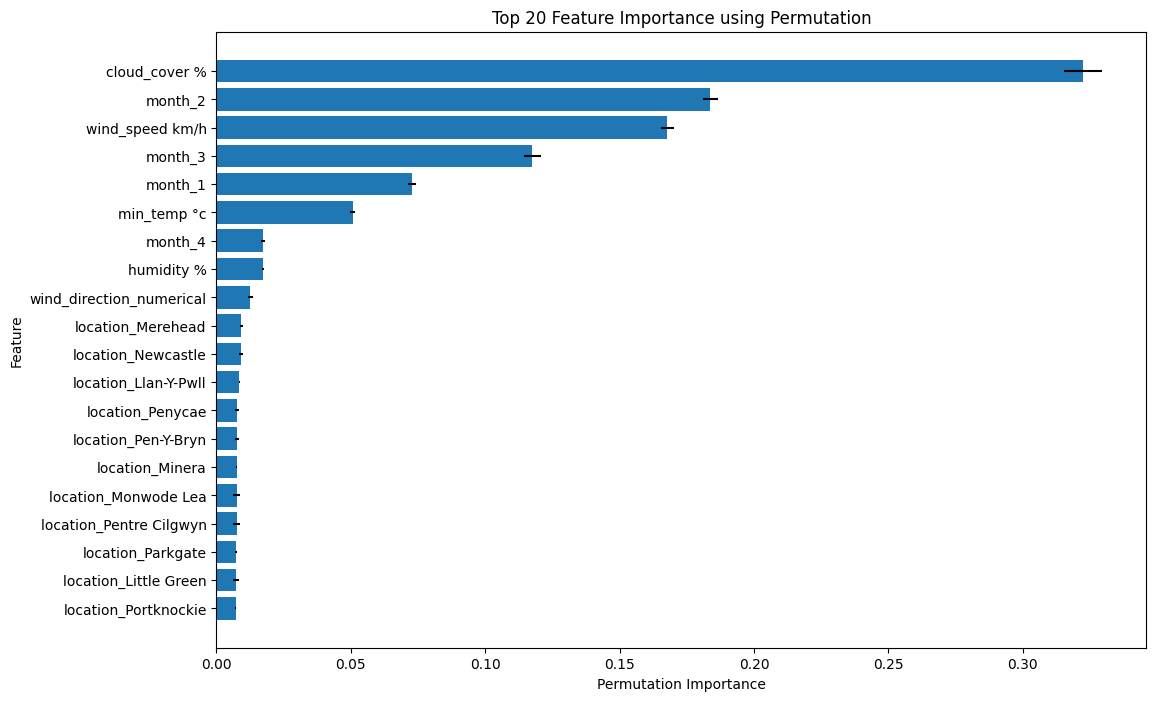

In [ ]:
# Create a DataFrame for better visualization
importances_df = pd.DataFrame(
    {
        'feature': X.columns,
        'importance': perm_importance.importances_mean,
        'std': perm_importance.importances_std
    }
).sort_values(by='importance', ascending=False)

# Display the top 20 features
top_20_importances = importances_df.head(20)
print(top_20_importances)

# Plot the top 20 feature importances
plt.figure(figsize=(12, 8))
plt.barh(top_20_importances['feature'], top_20_importances['importance'], xerr=top_20_importances['std'])
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.title("Top 20 Feature Importance using Permutation")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()

Key Observations from permutation importance:
1. **Dominant Features:**
  * cloud_cover % (importance: 0.322):
    This is the most important feature in the model, which makes sense because cloud cover is a strong indicator of precipitation. High cloud cover is often associated with rain, while low cloud cover typically indicates dry conditions.
  * month_2 (importance: 0.184), month_3 (importance: 0.118), and other month indicators:
    Monthly features capture seasonal trends in rainfall. For example:
    In February (month_2), rainfall might peak in certain regions due to seasonal weather patterns (e.g., monsoons or winter storms).
    March (month_3) may see transitions in weather patterns.
    These features are critical for capturing yearly cycles in weather.

2. **Important but Secondary Features:**
  * wind_speed km/h (importance: 0.168):
   Wind speed influences weather patterns, including the movement of rain-bearing clouds. For example, strong winds might bring moisture-laden air into a region, increasing the likelihood of rain.
  * min_temp °c (importance: 0.051):
    Minimum temperature correlates with humidity and the potential for precipitation. Cooler temperatures can lead to dew point saturation, forming clouds and rain.

3. **Low-Importance Features:**
  * humidity % (importance: 0.017):
    While humidity is related to rainfall, it’s often secondary because high humidity alone doesn’t guarantee rain. Other factors like cloud cover and wind patterns play larger roles.
  * wind_direction_numerical (importance: 0.013):
    Wind direction is less directly impactful than other features but can still provide useful regional patterns.
4. **Location-Based Features:**
    * Locations like Merehead (importance: 0.0093), Newcastle (importance: 0.0091), and others capture geographic differences in rainfall. These features were encoded using a one-hot vector representation, which helped the model consider the unique characteristics of each location independently without imposing a false ordinal relationship. This approach allows the model to effectively learn how specific locations influence rainfall based on factors like elevation, proximity to water bodies, or local climate.
    
    Their relatively low importance suggests that rainfall is more influenced by general meteorological variables (e.g., cloud cover, wind speed) than by fixed geographic factors in this dataset.

## Visualisations

Metrics Comparison:

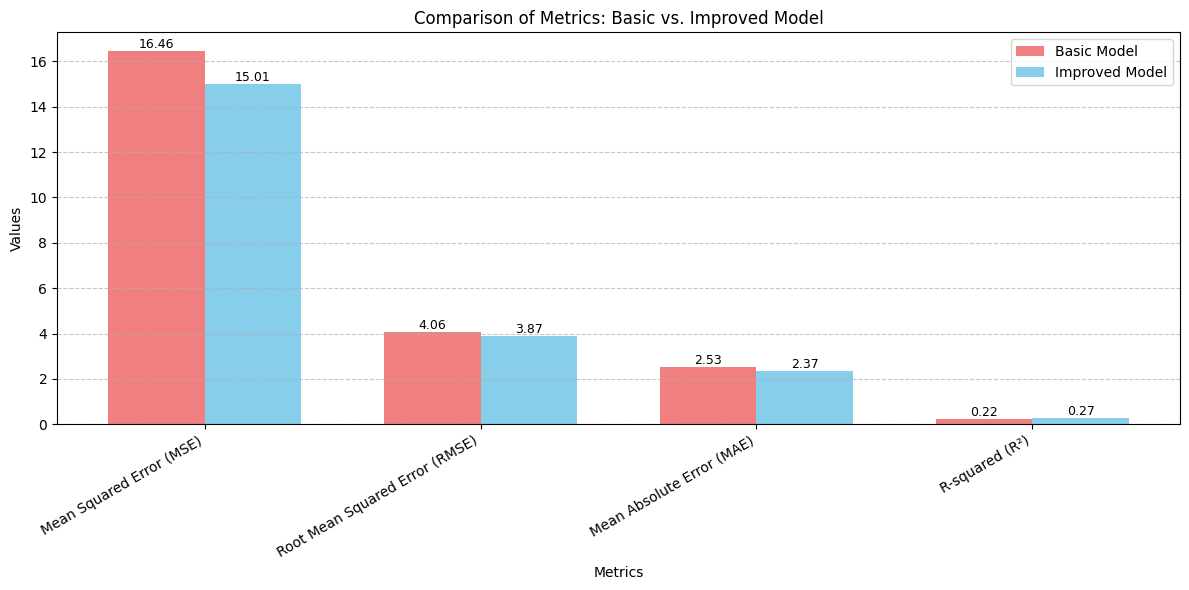

In [ ]:
# Metrics from your error analysis
metrics = ['Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)', 'Mean Absolute Error (MAE)', 'R-squared (R²)']

# Replace these with your actual values
basic_values = [basic_mse, basic_rmse, basic_mae, basic_r2]
improved_values = [improved_mse, improved_rmse, improved_mae, improved_r2]

# Plot comparison
x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, basic_values, width, label='Basic Model', color='lightcoral')
plt.bar(x + width/2, improved_values, width, label='Improved Model', color='skyblue')

# Add labels, title, and legend
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Comparison of Metrics: Basic vs. Improved Model')
plt.xticks(x, metrics, rotation=30, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Highlight R² as a higher-is-better metric
for i, (b_val, i_val) in enumerate(zip(basic_values, improved_values)):
    if i == 3:  # R² metric
        plt.text(i - width / 2, b_val + 0.02, f"{b_val:.2f}", ha='center', va='bottom', fontsize=9)
        plt.text(i + width / 2, i_val + 0.02, f"{i_val:.2f}", ha='center', va='bottom', fontsize=9)
    else:
        plt.text(i - width / 2, b_val, f"{b_val:.2f}", ha='center', va='bottom', fontsize=9)
        plt.text(i + width / 2, i_val, f"{i_val:.2f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

* X-axis (Categories):

  The x-axis represents the metrics being compared:
Mean Squared Error (MSE)
Root Mean Squared Error (RMSE)
Mean Absolute Error (MAE)
R-squared (R²)
Bars:

  For each metric, there are two bars:
Basic Model (light coral color): Represents the performance of the baseline model.
Improved Model (sky blue color): Represents the performance of the improved model.
Y-axis (Values):

* The y-axis represents the values of the metrics:
For MSE, RMSE, and MAE, lower values are better.
For R², higher values are better.


As we can see from this plot, the MSE, RMSE, MAE decreased and the R^2 increased. As we previously explained, this means we improved our model with the improvements we added.

Residual Distribution Comparison:

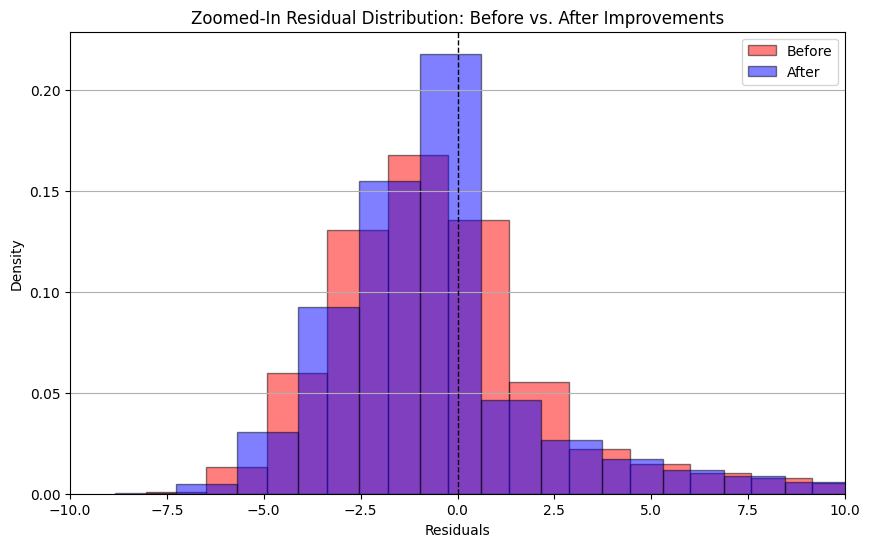

In [ ]:
residuals_before = basic_y_test - basic_y_pred
residuals_after = y_test - y_pred_clipped

plt.figure(figsize=(10, 6))
plt.hist(residuals_before, bins=50, alpha=0.5, label='Before', color='red', edgecolor='black', density=True)
plt.hist(residuals_after, bins=50, alpha=0.5, label='After', color='blue', edgecolor='black', density=True)
plt.axvline(0, color='black', linestyle='--', linewidth=1)  # Line at zero residual
plt.xlim(-10, 10)  # Zoom into residuals close to 0
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Zoomed-In Residual Distribution: Before vs. After Improvements')
plt.legend()
plt.grid(axis='y')
plt.show()

 Residual Distribution:

 This plot shows the distribution of residuals (differences between actual and predicted values) before and after improvements. Residuals are the differences between the actual values and the predicted values. Residuals close to
0 indicate better predictions (i.e., the model is accurate).

* Red Bars ("Before"):

  These represent the residuals from the baseline model before improvements.

* Blue Bars ("After"):

  These represent the residuals from the improved model after making enhancements.

* Black Vertical Line at 0:

  This line represents perfect predictions (no residual).

As we can see from the plot the model improved but not drastically:
* **Overlap Between Residuals (Purple Region)**:
The overlap of the red (Before) and blue (After) distributions indicates that many residuals remained similar between the two models.
This suggests the improvements were not drastic, as a significant portion of predictions have similar error levels.
* **Narrower Residual Spread for "After" (Blue)**:
The blue distribution (After) appears slightly more concentrated around 0 compared to the red distribution (Before). This indicates an improvement in accuracy, with fewer extreme residuals.
* **Taller Blue Bars Around 0:** The higher density of the blue residuals near 0 shows the improved model made more accurate predictions for a larger portion of the dataset.
* **Red Dominates in the Tails:** The red (Before) distribution has longer tails, suggesting that the baseline model had more large residuals (outliers or larger errors). The blue distribution tails are shorter, meaning the improved model handles extreme cases slightly better.

Prediction Distribution Comparison:

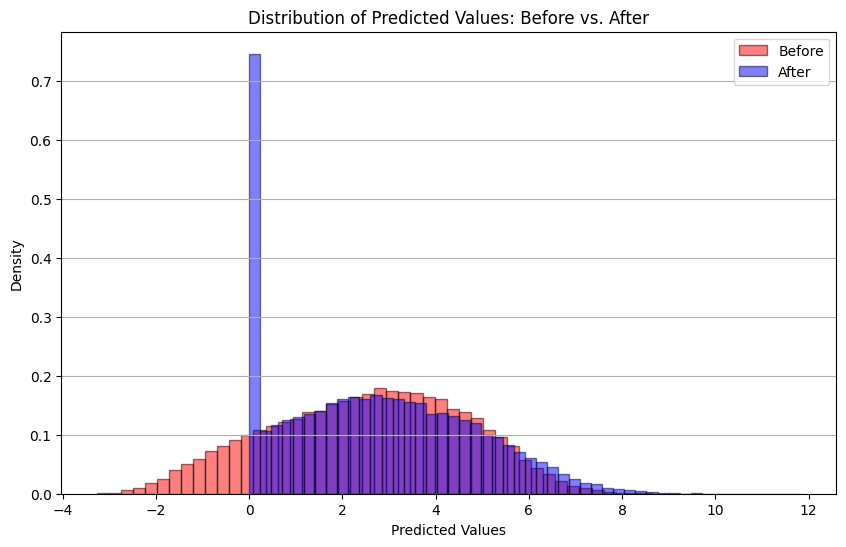

In [ ]:
# Plot the distribution of predicted values
plt.figure(figsize=(10, 6))

# Before model predictions
plt.hist(basic_y_pred, bins=50, alpha=0.5, label='Before', color='red', edgecolor='black', density=True)

# After model predictions
plt.hist(y_pred_clipped, bins=50, alpha=0.5, label='After', color='blue', edgecolor='black', density=True)

# Labels and title
plt.xlabel('Predicted Values')
plt.ylabel('Density')
plt.title('Distribution of Predicted Values: Before vs. After')
plt.legend()
plt.grid(axis='y')
plt.show()


This plot compares the distribution of predicted values for the "Before" (red) and "After" (blue) models:
* X-axis: Predicted values from the models.
* Y-axis: Density (relative frequency of predictions).
* Red (Before): Predictions from the baseline model.
* Blue (After): Predictions from the improved model.
* Taller bars indicate that the model predicts those values more frequently.

We can see from the plot the following improvements in the model:
* **Improved Stability in the "After" Model (Blue):**
The After model shows a tall spike at 0, which indicates that it predicts zero rainfall for a significant portion of the data.
This suggests that the model has become more stable and less prone to extreme overestimations compared to the "Before" model (red), which had a wider spread of predictions. This happened because in the improved model we clipped the negative rainfall values.
* **Controlled Predictions in the "After" Model:**
The Before model has a broader and more varied range of predictions, potentially capturing noise or making more errors.
The "After" model, on the other hand, focuses its predictions within a narrower range, reflecting better control over extreme values.
* **Overlap in Key Ranges (1 to 6):**
The blue (After) and red (Before) distributions overlap in the range of 1 to 6, showing that the improvements primarily target the handling of outliers and predictions near zero, while maintaining similar performance in the moderate ranges.
* **Reduced Outliers:**
Predictions from the "Before" model extend beyond 6 or even into negative values, suggesting it struggled with outliers.
The "After" model has fewer extreme predictions, which likely contributes to improved metrics like MSE and RMSE.

##**Biases**

* **cloud cover**: The permutation importance above showed that  the highest importance (0.322 0.322) is cloud cover which means cloud cover is a strong driver of the model's predictions. This suggests a natural trend: higher cloud cover is likely correlated with increased rainfall. The model heavily relies on this feature, which could create a bias.
* **max_temp**: The correlation matix above found that there is a strong correlation between max_temp and min_temp (over 0.85) and therefore dropped max_temp from the features to avoid multicollinearity. The model uses 'min_temp °c' (0.05 0.051) as a predictor after dropping 'max_temp °c' due to high correlation. This shows that the model identifies temperature as a contributing factor to rainfall, but redundancy between temperature features was avoided to reduce multicollinearity.
* **location:** There is no strong evidence of bias toward geographic features, as their importance is minimal.

##**Data Insights:**

We found some things surprising in our model:
* **Humidity Has Low Importance:** 'humidity %' has very low importance (0.017, 0.017), which is surprising because humidity typically correlates strongly with rainfall. However, this might suggest that the model captures similar information through more dominant features like cloud cover.
* **Geographic Features Have Minimal Influence:** Despite including location-based features, their low importance suggests the model does not significantly rely on geography. We thought because England is big it will have some areas that are ranier then others.
* **Low Importance of Temperature:** While 'min_temp °c' has some importance (0.051, 0.051), it’s much lower than we expected, because temperature is typically a significant predictor of rainfall (e.g., warm air can hold more moisture, leading to precipitation).
* **Model didnt drastically improve:** Despite improvements, we expected the changes in the improved model to result in more significant shifts.

##**User Friendly Explantion:**

1. **Cloud Cover Dominates Predictions**

  One of the clearest patterns in the model is its reliance on cloud cover. It is the most influential feature by far, making up over 32% of the model's decisions. This makes sense—cloud cover is a direct indicator of potential rainfall. However, the model’s strong dependence on this feature suggests it might overlook other important factors.

2. **Temperature and Humidity Are Underutilized**
You’d expect features like temperature and humidity to play a bigger role in predicting rainfall, as they are key drivers in weather systems. Surprisingly:

  * Temperature (min temp: 5%) has a much lower importance compared to cloud cover.
  * Humidity barely influences predictions, contributing just 1.7%.

  This suggests that while the model captures some relationships between these features and rainfall, there’s room to better integrate them for more robust predictions.

3. **Seasonal Patterns Drive Predictions**
The model picks up strong seasonal trends. For example:

  * Months like February and March significantly influence predictions (18% and 12%, respectively).
  * This reflects the dataset’s seasonal bias, where rainfall patterns align with specific months. While useful, this reliance could limit the model’s performance outside typical seasonal cycles.
4. **Geographic Features Play a Small Role**
  
  Interestingly, location-based features, like Merehead or Newcastle, have very low importance (less than 1%). This suggests the model does not rely heavily on geography to make its predictions. While this might simplify the model, it could also mean the geographic variability in rainfall is underrepresented in the data.

##**Proposed Applications for the Dataset and Findings**

Given the dataset's focus on rainfall patterns in England, the findings can be applied to various real-world scenarios where accurate rainfall predictions and seasonal trends play a significant role. Here are some potential applications we thought of:
* **Enhancing Agricultural Planning:** Farmers and agricultural stakeholders can use these insights to plan crop planting, irrigation schedules, and harvest timings based on expected rainfall.
* **Flood Risk Assessment:** Local councils and emergency management agencies can use the model to predict periods of high rainfall and prepare for potential flooding.
* **Infrastructure Planning:** Municipal planners can use the data to design and maintain drainage systems, reservoirs, and water supply networks to handle expected rainfall patterns.
* Tourism and Outdoor Event Planning:** Seasonal trends in rainfall can help event organizers plan outdoor festivals, sports events, or tourist activities to avoid disruptions caused by adverse weather.
* **Renewable Energy Optimization:** Solar and wind energy companies can use rainfall predictions to adjust energy output expectations and grid contributions.
* **Insurance and Financial Services:** Insurance companies can develop dynamic pricing models for weather-related policies, such as crop insurance or flood protection, based on rainfall predictions.